In [ ]:
import zipfile

with zipfile.ZipFile('CK+48.zip', 'r') as zip_ref:
    zip_ref.extractall('.')  # Extract to the current directory

print("Dataset extracted successfully!")

Dataset extracted successfully!


# **Image Pre-processing**

In [ ]:
import cv2
import os
import numpy as np

# Create a directory to store pre-processed images
os.makedirs('Preprocessed', exist_ok=True)

def preprocess_images(input_dir, output_dir, target_size=(128, 128), equalize_hist=False):
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            if filename.endswith('.png'):
                img_path = os.path.join(root, filename)
                try:
                    # Read the image
                    img = cv2.imread(img_path)

                    # Convert to grayscale
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Resize
                    resized_img = cv2.resize(gray_img, target_size)

                    # Normalize pixel values (0-1)
                    normalized_img = resized_img / 255.0

                    # Optional histogram equalization
                    if equalize_hist:
                        normalized_img = cv2.equalizeHist(np.uint8(normalized_img * 255)) / 255.0

                    # Reconstruct subdirectory structure inside the output directory
                    rel_path = os.path.relpath(img_path, input_dir)
                    save_path = os.path.join(output_dir, rel_path)
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)

                    # Save the preprocessed image
                    cv2.imwrite(save_path, np.uint8(normalized_img * 255))  # Save as uint8
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Example usage
input_directory = 'CK+48'
output_directory = 'Preprocessed'
preprocess_images(input_directory, output_directory, equalize_hist=True)
print("Image preprocessing complete!")

Image preprocessing complete!


# **Feature Extraction**

**SIFT (Scale-Invariant Feature Transform)**

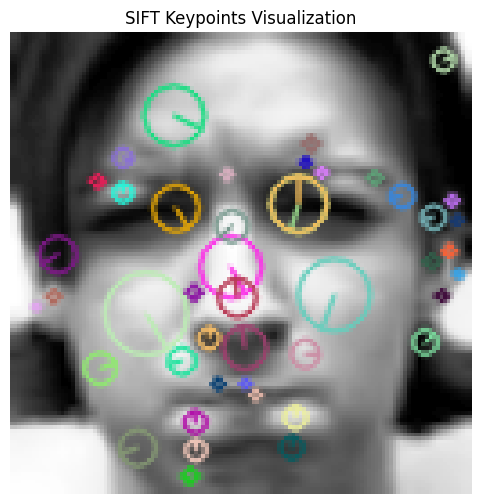

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load grayscale image
img_path = '/content/Preprocessed/anger/S010_004_00000017.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints, descriptors = sift.detectAndCompute(img, None)

# Draw keypoints
img_sift = cv2.drawKeypoints(img, keypoints, None,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualization
plt.figure(figsize=(8, 6))
plt.imshow(img_sift, cmap='gray')
plt.title("SIFT Keypoints Visualization")
plt.axis('off')
plt.show()


**HOG (Histogram of Oriented Gradients)**

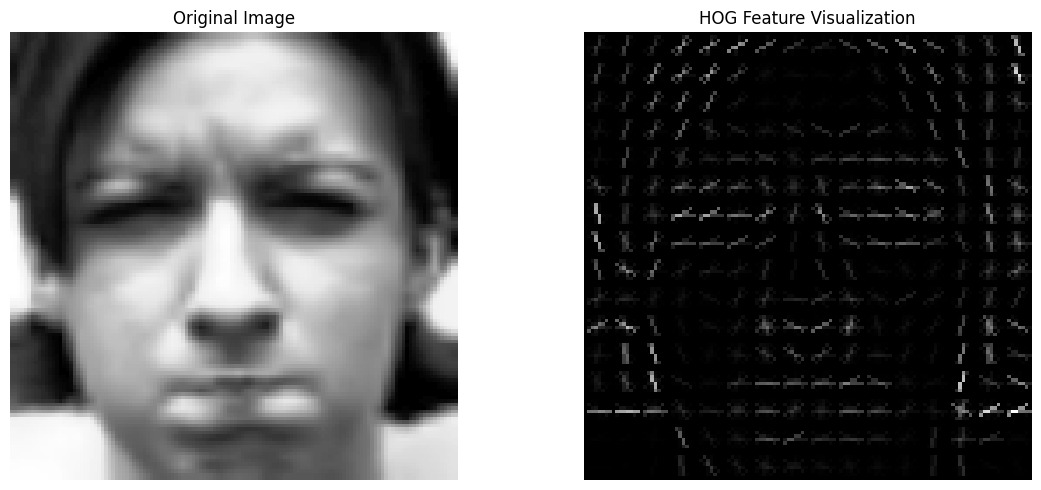

In [ ]:
from skimage.feature import hog
import numpy as np

# Compute HOG features and visualization image
features, hog_image = hog(img,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          transform_sqrt=True,
                          visualize=True,
                          feature_vector=True)

# Show original and HOG image
plt.figure(figsize=(12, 5))

# Original
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# HOG
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Feature Visualization")
plt.axis('off')

plt.tight_layout()
plt.show()

 Overall SIFT highlights all keypoints while HOG is more of an outline of the face and features are not very clear

# **Model Training**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib

# Define emotion labels and mapping
emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
label_to_index = {emotion: i for i, emotion in enumerate(emotion_labels)}

X, y = [], []
preprocessed_dir = 'Preprocessed'

# Load images and extract HOG features
for emotion in emotion_labels:
    emotion_path = os.path.join(preprocessed_dir, emotion)
    if not os.path.exists(emotion_path):
        print(f"WARNING: Directory '{emotion}' not found — skipping.")
        continue

    for file in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
            X.append(features)
            y.append(label_to_index[emotion])

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} samples.")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train SVM classifier
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(clf, "emotion_classifier.pkl")
print("Trained model saved as 'emotion_classifier.pkl'")


Loaded 981 samples.
Trained model saved as 'emotion_classifier.pkl'


# **Evaluation**

Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      1.00      1.00        35
        fear       1.00      1.00      1.00        15
       happy       1.00      1.00      1.00        42
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        50

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



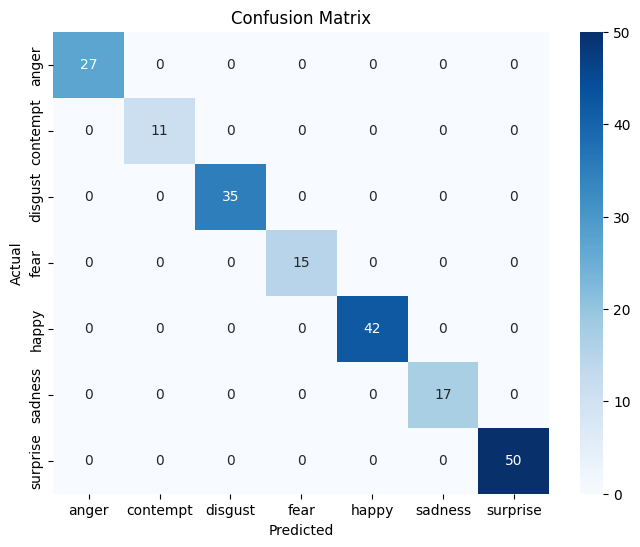

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Predict on test set
y_pred = clf.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# **Real-time Emotion Prediction**

In [ ]:
# Import the Colab display function for showing frames
from google.colab.patches import cv2_imshow

# Load the Haar Cascade face detector (face detection method)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the trained SVM model from Step 4 using joblib
model = joblib.load("emotion_classifier.pkl")

# Define the emotion labels in the same order used during training
emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Load the video file (YouTube pedestrian video)
video_path = "/content/Crowd walking forward NYC B-RollM.mp4"
cap = cv2.VideoCapture(video_path)

# Limit how many frames are processed in Colab to avoid display issues
frame_count = 0
max_frames = 10  # This can be increased or removed for local testing

# Process the video frame-by-frame
while cap.isOpened() and frame_count < max_frames:
    # Read the current frame from the video
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale (preprocessing requirement)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale frame using Haar Cascade
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Process each detected face
    for (x, y, w, h) in faces:
        # Extract the face region from the image (cropping)
        face_img = gray[y:y+h, x:x+w]

        # Resize the face to 128x128 (same size used in training)
        resized_face = cv2.resize(face_img, (128, 128))

        # Normalize pixel values to the [0, 1] range
        normalized_face = resized_face / 255.0

        # Extract HOG features from the preprocessed face
        features = hog(normalized_face, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')

        # Predict the emotion label using the trained classifier
        prediction = model.predict([features])[0]
        predicted_emotion = emotion_labels[prediction]

        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Overlay the predicted emotion label on the frame
        cv2.putText(frame, predicted_emotion, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Convert frame to RGB for display in Colab
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the annotated frame in Colab
    cv2_imshow(frame_rgb)

    # Increment the frame counter
    frame_count += 1

# Release the video capture object
cap.release()


# **Webscraping and trying other models**

---



First I will create a new dataset using webscraping

In [ ]:
!pip install beautifulsoup4 requests

In [ ]:
import os
import requests
from bs4 import BeautifulSoup
import urllib.request
import time

In [ ]:
import urllib.parse
import json

def download_bing_images(query, save_dir, max_images=100):
    os.makedirs(save_dir, exist_ok=True)

    query_for_url = urllib.parse.quote(query)
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/90.0.4430.212 Safari/537.36"
    }

    downloaded = 0
    seen_urls = set()

    for start in range(1, 200, 35):
        if downloaded >= max_images:
            break

        url = f"https://www.bing.com/images/search?q={query_for_url}&first={start}&form=HDRSC2&qft=+filterui:photo-photo"
        print(f"\nSearching URL: {url}")

        try:
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            images = soup.find_all('a', class_="iusc")
            print(f"Found {len(images)} image blocks on this page")

            for img in images:
                if downloaded >= max_images:
                    break

                try:
                    metadata = img.get('m')
                    if not metadata:
                        continue

                    m_json = json.loads(metadata)
                    img_url = m_json.get("murl")
                    if not img_url or img_url in seen_urls:
                        continue

                    seen_urls.add(img_url)

                    # Encode the URL safely
                    safe_img_url = urllib.parse.quote(img_url, safe=':/')

                    # Create filename
                    ext = os.path.splitext(safe_img_url)[1].split('?')[0]
                    ext = ext if ext.lower() in ['.jpg', '.jpeg', '.png'] else '.jpg'
                    filename = os.path.join(save_dir, f"{query_for_url}_{downloaded + 1}{ext}")

                    # Use request with headers
                    req = urllib.request.Request(safe_img_url, headers=headers)
                    with urllib.request.urlopen(req, timeout=10) as resp, open(filename, 'wb') as out_file:
                        out_file.write(resp.read())

                    downloaded += 1
                    print(f"Downloaded [{downloaded}/{max_images}]: {filename}")
                    time.sleep(0.5)

                except Exception as e:
                    print(f"Skipped one image due to error: {e}")
                    continue

        except Exception as e:
            print(f"Failed to fetch search page: {e}")
            break

    print(f"\nFinished downloading {downloaded} images for: '{query}'")
    print(f"Images saved in: {save_dir}")


In [ ]:
searches = [
    "angry person face image portrait",
    "contempt person face image portrait",
    "disgusted person face image portrait",
    "scared person face image portrait",
    "happy person face image portrait",
    "sad person face image portrait",
    "surprised person face image portrait"
]

In [ ]:
base_dir = "webscraping_images"
images_per_emotion = 35

for search_query in searches:
    folder_name = search_query.split()[0]  # like "angry" or "happy"
    save_path = os.path.join(base_dir, folder_name)
    download_bing_images(search_query, save_path, max_images=images_per_emotion)



Searching URL: https://www.bing.com/images/search?q=angry%20person%20face%20image%20portrait&first=1&form=HDRSC2&qft=+filterui:photo-photo
Found 35 image blocks on this page
Downloaded [1/35]: webscraping_images/angry/angry%20person%20face%20image%20portrait_1.jpg
Skipped one image due to error: HTTP Error 404: Not Found
Downloaded [2/35]: webscraping_images/angry/angry%20person%20face%20image%20portrait_2.jpg
Skipped one image due to error: HTTP Error 404: Not Found
Downloaded [3/35]: webscraping_images/angry/angry%20person%20face%20image%20portrait_3.jpg
Downloaded [4/35]: webscraping_images/angry/angry%20person%20face%20image%20portrait_4.jpg
Downloaded [5/35]: webscraping_images/angry/angry%20person%20face%20image%20portrait_5.jpg
Downloaded [6/35]: webscraping_images/angry/angry%20person%20face%20image%20portrait_6.jpg
Skipped one image due to error: HTTP Error 403: Forbidden
Downloaded [7/35]: webscraping_images/angry/angry%20person%20face%20image%20portrait_7.jpg
Downloaded [8/

I will try the multiple classifiers on the webscraped images first, so i will need to do all the steps for them again

In [ ]:
import cv2
import os
import numpy as np

def preprocess_images(input_dir, output_dir, target_size=(128, 128), equalize_hist=False):
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)

                # Read image
                img = cv2.imread(img_path)

                if img is None:
                    print(f"Skipped unreadable image: {img_path}")
                    continue

                try:
                    # Convert to grayscale
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Resize
                    resized_img = cv2.resize(gray_img, target_size)

                    # Normalize to 0–1
                    normalized_img = resized_img / 255.0

                    # Histogram equalization
                    if equalize_hist:
                        normalized_img = cv2.equalizeHist(np.uint8(normalized_img * 255)) / 255.0

                    # Save to output directory
                    rel_path = os.path.relpath(img_path, input_dir)
                    save_path = os.path.join(output_dir, rel_path)
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    cv2.imwrite(save_path, np.uint8(normalized_img * 255))

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Run the preprocessing
input_directory = "webscraping_images"
output_directory = "WebPreprocessed"
preprocess_images(input_directory, output_directory, equalize_hist=True)

Skipped unreadable image: webscraping_images/angry/angry%20person%20face%20image%20portrait_17.jpg
Skipped unreadable image: webscraping_images/surprised/surprised%20person%20face%20image%20portrait_1.jpg


In [ ]:
import os
import numpy as np
import cv2
from skimage.feature import hog

# Define the hog features extraction function
def extract_hog_features(base_dir):
    features = []
    labels = []

    for emotion in os.listdir(base_dir):
        emotion_path = os.path.join(base_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue

        for filename in os.listdir(emotion_path):
            file_path = os.path.join(emotion_path, filename)
            try:
                # Read as grayscale
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                # Extract HOG features
                hog_features = hog(
                    img,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys',
                    visualize=False
                )

                features.append(hog_features)
                labels.append(emotion)

            except Exception as e:
                print(f"⚠️ Error processing {file_path}: {e}")
                continue

    return np.array(features), np.array(labels)

# Run the feature extraction
X, y = extract_hog_features("WebPreprocessed")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

Here, we will use different models for the dataset created by webscraping


Training: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

       angry       0.25      0.29      0.27         7
    contempt       0.33      0.29      0.31         7
   disgusted       0.00      0.00      0.00         7
       happy       0.25      0.14      0.18         7
         sad       0.09      0.14      0.11         7
      scared       0.43      0.43      0.43         7
   surprised       0.57      0.57      0.57         7

    accuracy                           0.27        49
   macro avg       0.27      0.27      0.27        49
weighted avg       0.27      0.27      0.27        49

Accuracy: 0.2653


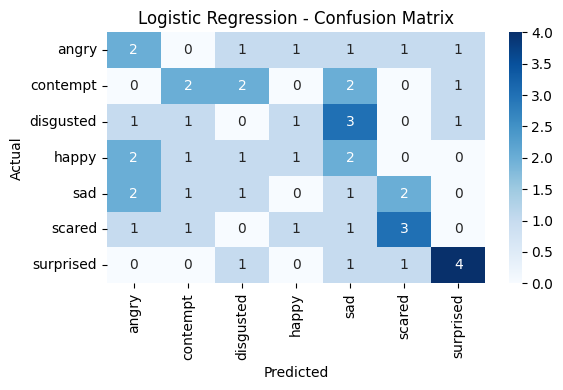


Training: SVM
Classification Report:
              precision    recall  f1-score   support

       angry       0.25      0.29      0.27         7
    contempt       0.25      0.14      0.18         7
   disgusted       0.00      0.00      0.00         7
       happy       0.17      0.14      0.15         7
         sad       0.17      0.29      0.21         7
      scared       0.50      0.29      0.36         7
   surprised       0.50      0.57      0.53         7

    accuracy                           0.24        49
   macro avg       0.26      0.24      0.24        49
weighted avg       0.26      0.24      0.24        49

Accuracy: 0.2449


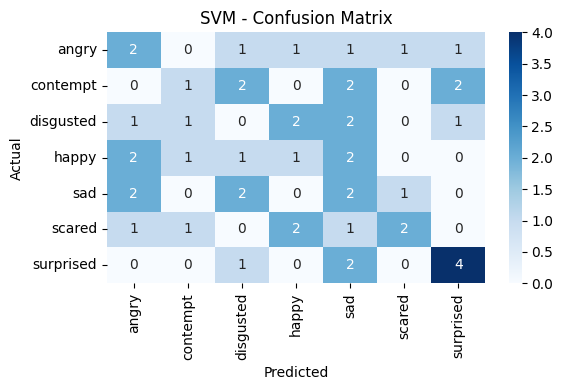


Training: KNN (k=3)
Classification Report:
              precision    recall  f1-score   support

       angry       0.31      0.57      0.40         7
    contempt       0.11      0.29      0.16         7
   disgusted       0.20      0.29      0.24         7
       happy       0.00      0.00      0.00         7
         sad       0.00      0.00      0.00         7
      scared       0.00      0.00      0.00         7
   surprised       0.33      0.14      0.20         7

    accuracy                           0.18        49
   macro avg       0.14      0.18      0.14        49
weighted avg       0.14      0.18      0.14        49

Accuracy: 0.1837


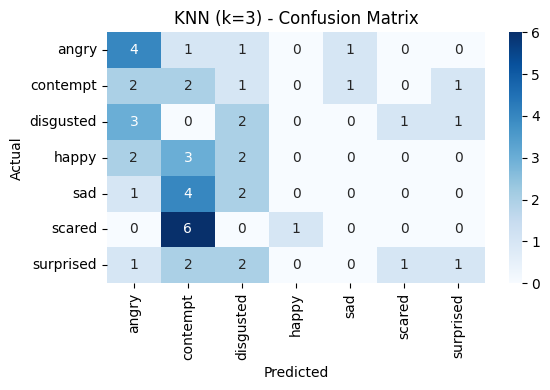


Training: Random Forest
Classification Report:
              precision    recall  f1-score   support

       angry       0.11      0.14      0.12         7
    contempt       0.25      0.14      0.18         7
   disgusted       0.17      0.14      0.15         7
       happy       0.40      0.29      0.33         7
         sad       0.00      0.00      0.00         7
      scared       0.22      0.29      0.25         7
   surprised       0.20      0.29      0.24         7

    accuracy                           0.18        49
   macro avg       0.19      0.18      0.18        49
weighted avg       0.19      0.18      0.18        49

Accuracy: 0.1837


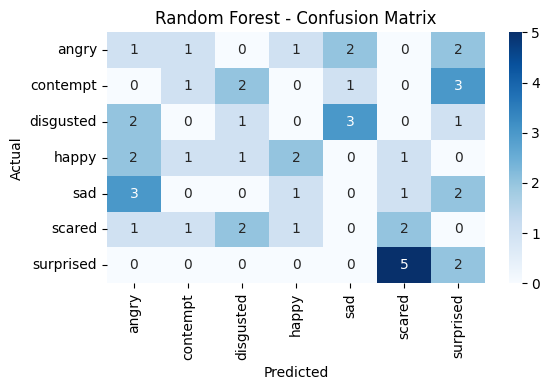

In [ ]:
# Train, predict, and evaluate each model
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y),
                cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

**For the webscraped images, SVM has the best results.**
the results were not very good due to lack of enough images in the daaset



Now i will try different models but for the original dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#first, run the cell that sets X and y for the original dataset to make X and y represent the values from the original dataset, not the new one
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


Training: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

       angry       0.25      0.29      0.27         7
    contempt       0.33      0.29      0.31         7
   disgusted       0.00      0.00      0.00         7
       happy       0.25      0.14      0.18         7
         sad       0.09      0.14      0.11         7
      scared       0.43      0.43      0.43         7
   surprised       0.57      0.57      0.57         7

    accuracy                           0.27        49
   macro avg       0.27      0.27      0.27        49
weighted avg       0.27      0.27      0.27        49

Accuracy: 0.2653


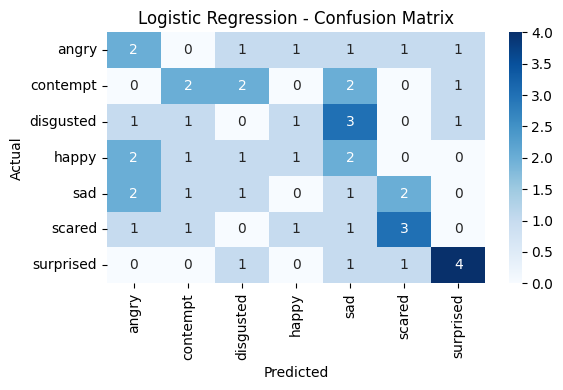


Training: Support Vector Machine
Classification Report:
              precision    recall  f1-score   support

       angry       0.25      0.29      0.27         7
    contempt       0.25      0.14      0.18         7
   disgusted       0.00      0.00      0.00         7
       happy       0.17      0.14      0.15         7
         sad       0.17      0.29      0.21         7
      scared       0.50      0.29      0.36         7
   surprised       0.50      0.57      0.53         7

    accuracy                           0.24        49
   macro avg       0.26      0.24      0.24        49
weighted avg       0.26      0.24      0.24        49

Accuracy: 0.2449


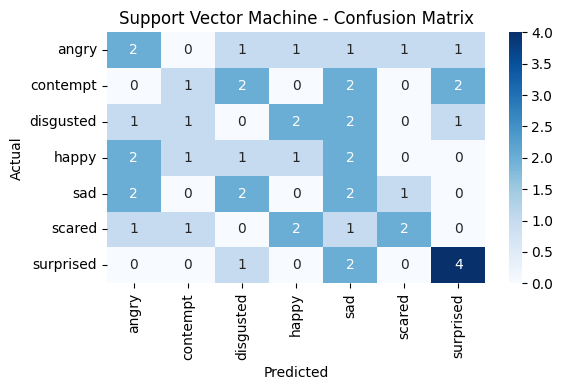


Training: K-Nearest Neighbors
Classification Report:
              precision    recall  f1-score   support

       angry       0.31      0.57      0.40         7
    contempt       0.11      0.29      0.16         7
   disgusted       0.20      0.29      0.24         7
       happy       0.00      0.00      0.00         7
         sad       0.00      0.00      0.00         7
      scared       0.00      0.00      0.00         7
   surprised       0.33      0.14      0.20         7

    accuracy                           0.18        49
   macro avg       0.14      0.18      0.14        49
weighted avg       0.14      0.18      0.14        49

Accuracy: 0.1837


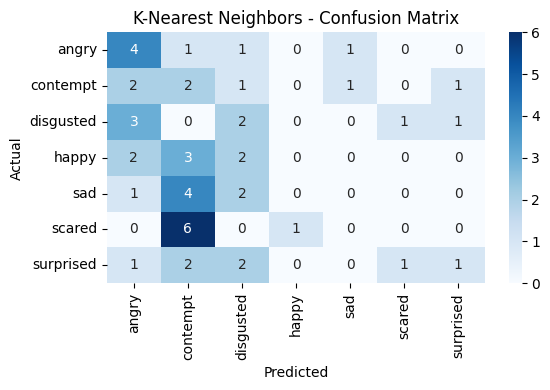


Training: Random Forest
Classification Report:
              precision    recall  f1-score   support

       angry       0.11      0.14      0.12         7
    contempt       0.25      0.14      0.18         7
   disgusted       0.17      0.14      0.15         7
       happy       0.40      0.29      0.33         7
         sad       0.00      0.00      0.00         7
      scared       0.22      0.29      0.25         7
   surprised       0.20      0.29      0.24         7

    accuracy                           0.18        49
   macro avg       0.19      0.18      0.18        49
weighted avg       0.19      0.18      0.18        49

Accuracy: 0.1837


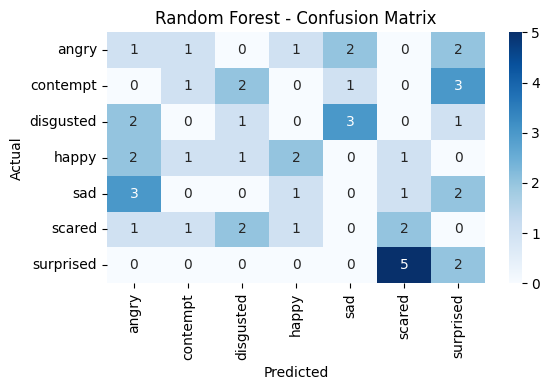

In [ ]:
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y),
                cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

**Based on the results, SVM and Logistic Regression are the best models, having perfect scores across the board**